# 题目 2：数值积分与误差分析

## 1. 基本数值积分方法
目标：
* 计算积分 $I = \int_0^{\pi} \sin(x)dx$ （精确值为 2）
* 实现梯形法 (Trapezoidal Rule) 和 Simpson法 (Simpson's Rule)
* 分别用 $n = 4, 8, 16, 32, 64$ 个分割计算
* 绘制误差随 $n$ 变化的双对数图
* 验证: 梯形法为 $O(h^2)$，Simpson法为 $O(h^4)$

n     | Trap Error   | Simp Error  
-----------------------------------
4     | 1.04e-01     | 4.56e-03    
8     | 2.58e-02     | 2.69e-04    
16    | 6.43e-03     | 1.66e-05    
32    | 1.61e-03     | 1.03e-06    
64    | 4.02e-04     | 6.45e-08    


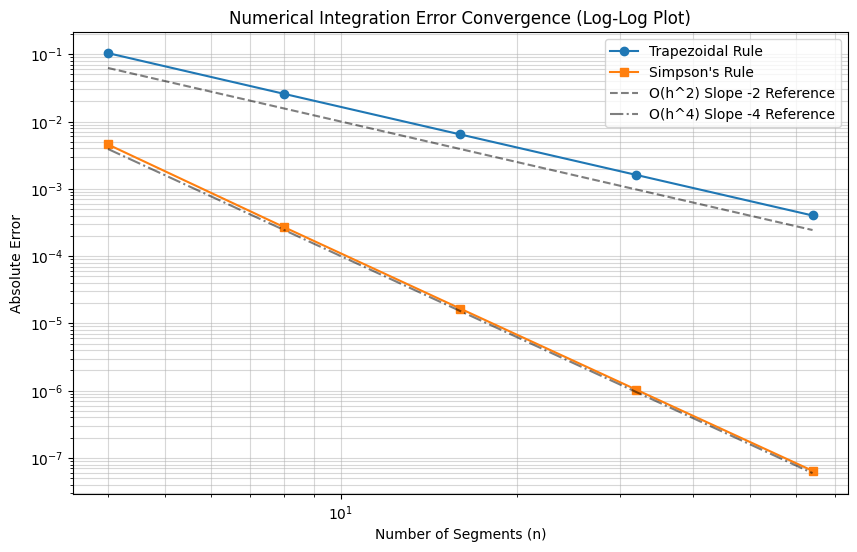


Log-Log Slope Verification:
Trapezoidal Slope: -2.00 (Theoretical: -2)
Simpson's Slope:   -4.02 (Theoretical: -4)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# 解决 "Font 'default' does not have a glyph for '\u2212'" 报错
# 该设置让 matplotlib 使用 ASCII 减号而不是 unicode 减号
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 实现积分方法 ---
def trapezoidal_rule(f, a, b, n):
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    # 梯形公式: h * (y0/2 + y1 + ... + yn/2)
    return h * (0.5 * y[0] + np.sum(y[1:-1]) + 0.5 * y[-1])

def simpsons_rule(f, a, b, n):
    if n % 2 != 0:
        raise ValueError("Simpson's rule requires even n")
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    # Simpson公式: h/3 * (y0 + 4*y_odd + 2*y_even + yn)
    return h/3 * (y[0] + 4*np.sum(y[1:n:2]) + 2*np.sum(y[2:n-1:2]) + y[-1])

# --- 2. 实验设置 ---
f = np.sin
a, b = 0, np.pi
exact_I = 2.0

n_values = [4, 8, 16, 32, 64]
trap_errors = []
simp_errors = []

# --- 3. 计算与输出 ---
print(f"{'n':<5} | {'Trap Error':<12} | {'Simp Error':<12}")
print("-" * 35)

for n in n_values:
    # Trapezoidal
    I_trap = trapezoidal_rule(f, a, b, n)
    err_trap = abs(I_trap - exact_I)
    trap_errors.append(err_trap)
    
    # Simpson
    I_simp = simpsons_rule(f, a, b, n)
    err_simp = abs(I_simp - exact_I)
    simp_errors.append(err_simp)
    
    print(f"{n:<5} | {err_trap:<12.2e} | {err_simp:<12.2e}")

# --- 4. 绘图与验证 ---
plt.figure(figsize=(10, 6))
plt.loglog(n_values, trap_errors, 'o-', label='Trapezoidal Rule')
plt.loglog(n_values, simp_errors, 's-', label="Simpson's Rule")

# 添加参考斜率线
n_arr = np.array(n_values)
plt.loglog(n_arr, 1/n_arr**2, 'k--', alpha=0.5, label='O(h^2) Slope -2 Reference')
plt.loglog(n_arr, 1/n_arr**4, 'k-.', alpha=0.5, label='O(h^4) Slope -4 Reference')

plt.xlabel('Number of Segments (n)')
plt.ylabel('Absolute Error')
plt.title('Numerical Integration Error Convergence (Log-Log Plot)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# 计算斜率验证
trap_slope = np.polyfit(np.log(n_values), np.log(trap_errors), 1)[0]
simp_slope = np.polyfit(np.log(n_values), np.log(simp_errors), 1)[0]
print(f"\nLog-Log Slope Verification:")
print(f"Trapezoidal Slope: {trap_slope:.2f} (Theoretical: -2)")
print(f"Simpson's Slope:   {simp_slope:.2f} (Theoretical: -4)")

## 2. 高斯积分应用
目标：
* 计算 $\int_{-\infty}^{\infty} e^{-x^2} dx = \sqrt{\pi}$
* 分析截断区间 $[-L, L]$ 中 $L$ 值对精度的影响
* 使用变量代换 $t = x/\sqrt{1-x^2}$ 将无限区间映射到 $[-1, 1]$ 并计算

L     | Integral Result | Error          
---------------------------------------------
1     | 1.4936482656    | 2.79e-01       
2     | 1.7641627815    | 8.29e-03       
3     | 1.7724146965    | 3.92e-05       
4     | 1.7724538236    | 2.73e-08       
5     | 1.7724538509    | 2.72e-12       
6     | 1.7724538509    | 4.44e-16       


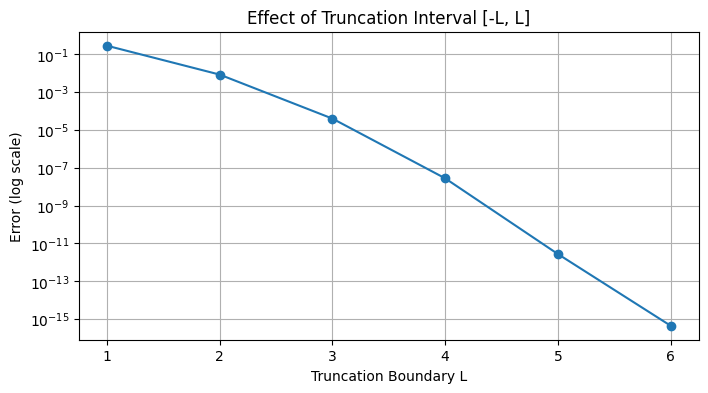


Integration by Substitution Results: 1.7724538509
Error vs Exact: 6.64e-13


In [2]:
exact_gauss = np.sqrt(np.pi)

# --- 1. Analysis of Truncation Interval ---
L_values = [1, 2, 3, 4, 5, 6]
trunc_errors = []

print(f"{'L':<5} | {'Integral Result':<15} | {'Error':<15}")
print("-" * 45)

for L in L_values:
    # Use scipy.integrate.quad to get exact value on the interval
    I_trunc, _ = quad(lambda x: np.exp(-x**2), -L, L)
    err = abs(exact_gauss - I_trunc)
    trunc_errors.append(err)
    print(f"{L:<5} | {I_trunc:<15.10f} | {err:<15.2e}")

plt.figure(figsize=(8, 4))
plt.semilogy(L_values, trunc_errors, 'o-')
plt.title('Effect of Truncation Interval [-L, L]')
plt.xlabel('Truncation Boundary L')
plt.ylabel('Error (log scale)')
plt.grid(True)
plt.show()

# --- 2. Variable Substitution Method ---
# Substitution: x = t / sqrt(1 - t^2)
# dx = dt / (1 - t^2)^(3/2)
# Interval: t from -1 to 1

def transformed_integrand(t):
    # Handle boundary singularities, practically exp(-inf) goes to 0
    if abs(t) >= 1.0: return 0 
    x = t / np.sqrt(1 - t**2)
    return np.exp(-x**2) * (1 / (1 - t**2)**1.5)

# Integrate
I_trans, err_valid = quad(transformed_integrand, -1, 1)
print(f"\nIntegration by Substitution Results: {I_trans:.10f}")
print(f"Error vs Exact: {abs(I_trans - exact_gauss):.2e}")

## 3. 蒙特卡洛积分 (选做)
目标：
* 用蒙特卡洛方法计算 $\int_{0}^{1} e^{-x^2} dx$
* 生成 $N$ 个均匀随机点进行估算
* 分析不同 $N$ 下的精度变化 (预期误差 $\propto 1/\sqrt{N}$)

N          | MC Estimate  | Error       
---------------------------------------------
100        | 0.765061     | 0.018237    
1000       | 0.748262     | 0.001438    
10000      | 0.750142     | 0.003317    
100000     | 0.746744     | 0.000080    
1000000    | 0.746648     | 0.000176    


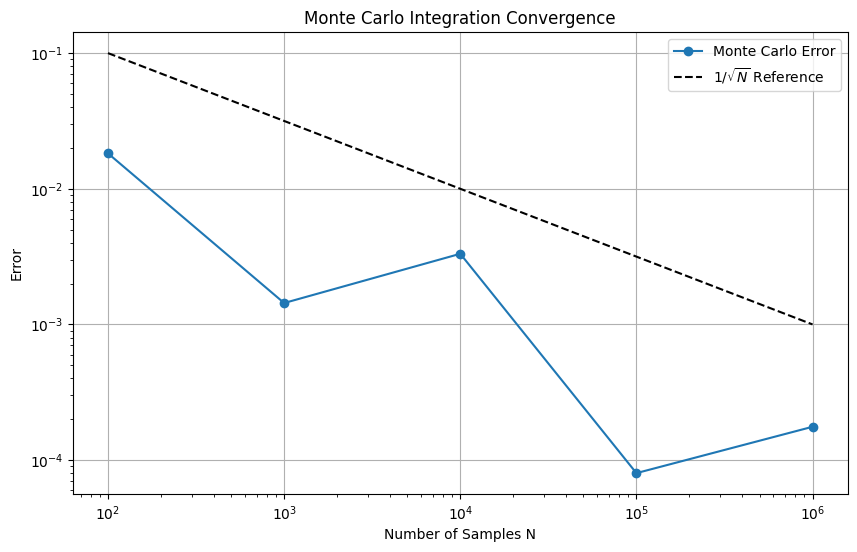

In [3]:
# Exact value (for comparison)
exact_mc, _ = quad(lambda x: np.exp(-x**2), 0, 1)

N_vals_mc = [100, 1000, 10000, 100000, 1000000]
mc_errors = []
theoretical_conv = [] # 1/sqrt(N)

np.random.seed(42) # Fix seed for reproducibility

print(f"{'N':<10} | {'MC Estimate':<12} | {'Error':<12}")
print("-" * 45)

for N in N_vals_mc:
    # 1. Generate uniform random numbers on [0, 1]
    x_rand = np.random.uniform(0, 1, N)
    
    # 2. Calculate function values and take the mean
    # Integral approx = (b-a) * mean(f(x))
    y_rand = np.exp(-x_rand**2)
    I_mc = np.mean(y_rand) * (1.0 - 0.0)
    
    error = abs(I_mc - exact_mc)
    mc_errors.append(error)
    theoretical_conv.append(1/np.sqrt(N))
    
    print(f"{N:<10} | {I_mc:<12.6f} | {error:<12.6f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(N_vals_mc, mc_errors, 'o-', label='Monte Carlo Error')
plt.loglog(N_vals_mc, theoretical_conv, 'k--', label=r'$1/\sqrt{N}$ Reference')
plt.xlabel('Number of Samples N')
plt.ylabel('Error')
plt.title('Monte Carlo Integration Convergence')
plt.legend()
plt.grid(True)
plt.show()